In [154]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import resize
import cv2

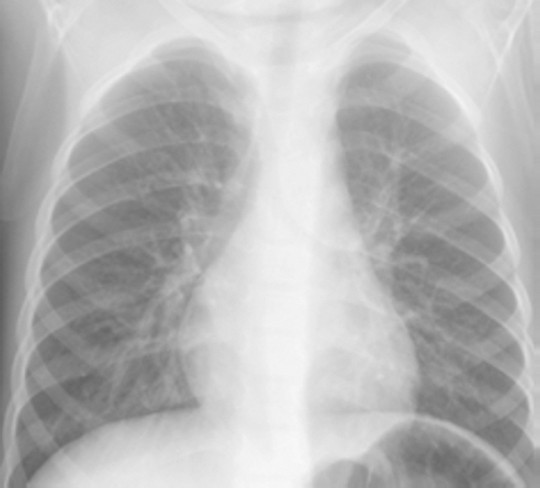

In [155]:
model = keras.models.load_model('D:\\CNN Prediction\\pneumonia.h5')
layer_name = "conv2d_3"
imag = 'C:\\Users\\Lenovo\\Pictures\\Camera Roll\\332aa0c67cb2e035e372c7cb3ceca2_jumbo.jpg'
size = (150, 150)
preprocess_input = keras.applications.xception.preprocess_input

decode_predictions = keras.applications.xception.decode_predictions
display(Image(imag))

In [156]:
def get_img_array(img, size):
    img = keras.preprocessing.image.load_img(imag, target_size=(150, 150), color_mode="grayscale")
    img_array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(img_array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [157]:
from PIL import Image
def predict_image(model, imag):
    img = keras.preprocessing.image.load_img(imag, target_size=(150, 150), color_mode="grayscale")
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array)
    if predictions[0] > 0.5:
        print("This chest X-Ray image is Pneumonia Negative")
    else:
        print("This chest X-Ray image is Pneumonia Positive")
    
    return predictions

In [158]:
predicted_label = predict_image(model, imag)
print("This image indicates", predicted_label )

1/1 [==============================] - 0s 303ms/step
This chest X-Ray image is Pneumonia Positive
This image indicates [[0.00120335]]


1/1 [==============================] - 0s 107ms/step
This chest X-Ray image is Pneumonia Positive
[[0.00120335]]


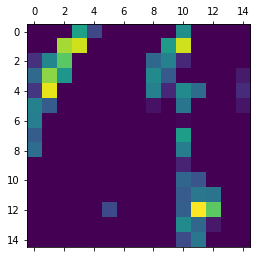

In [159]:
img_array = preprocess_input(get_img_array(imag, size=size))
model.layers[-1].activation = None
preds = predict_image(model, imag)
print(preds)
heatmap = make_gradcam_heatmap(img_array, model, layer_name)
plt.matshow(heatmap)
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12456\4018043568.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


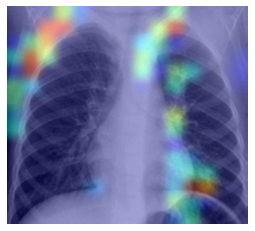

In [160]:
import matplotlib.pyplot as plt
from PIL import Image

def save_and_display_gradcam(imag, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(imag)
    img = keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    img = Image.open(cam_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
save_and_display_gradcam(imag, heatmap)